In [1]:
%load_ext autoreload
%autoreload 

In [2]:
import jupyros as jr
import rospy
import numpy as np
from sensor_msgs import msg
import cv2
import cv_bridge
from copy import deepcopy
import ipywidgets as widgets
import PIL.Image
from cStringIO import StringIO
import matplotlib.pyplot as plt
import dvrk
import PyKDL
import tf
import time
from tf_conversions import posemath
import utils

In [3]:
rospy.init_node('notebook')
rospy.get_published_topics()

[['/dvrk/setup_joint/robot_state', 'std_msgs/String'],
 ['/dvrk/PSM1/current_state', 'std_msgs/String'],
 ['/dvrk/ECM/wrench_body_current', 'geometry_msgs/WrenchStamped'],
 ['/dvrk/PSM2/position_cartesian_local_current', 'geometry_msgs/PoseStamped'],
 ['/dvrk/console/teleop/teleop_psm_selected', 'diagnostic_msgs/KeyValue'],
 ['/dvrk/PSM2/joint_velocity_ratio', 'std_msgs/Float64'],
 ['/dvrk/ECM/state_joint_desired', 'sensor_msgs/JointState'],
 ['/dvrk/console/teleop/teleop_psm_unselected', 'diagnostic_msgs/KeyValue'],
 ['/dvrk/PSM2/position_cartesian_desired', 'geometry_msgs/PoseStamped'],
 ['/dvrk/ECM/position_cartesian_local_current', 'geometry_msgs/PoseStamped'],
 ['/dvrk/PSM1/status', 'std_msgs/String'],
 ['/dvrk/console/teleop/scale', 'std_msgs/Float32'],
 ['/dvrk/tf_broadcast/period_statistics', 'cisst_msgs/mtsIntervalStatistics'],
 ['/dvrk/PSM1/joint_velocity_ratio', 'std_msgs/Float64'],
 ['/tf', 'tf2_msgs/TFMessage'],
 ['/dvrk/PSM1/desired_state', 'std_msgs/String'],
 ['/dvrk/EC

In [4]:
bridge = cv_bridge.CvBridge()
left_image = None
left_image_msg = None
left_camera_info = None

right_image = None
right_image_msg = None
right_camera_info = None

def left_image_callback(im_msg):
    global left_image, left_image_msg
    left_image = bridge.imgmsg_to_cv2(im_msg, desired_encoding='rgb8')
    left_image_msg = im_msg
    
def right_image_callback(im_msg):
    global right_image, right_image_msg
    right_image = bridge.imgmsg_to_cv2(im_msg, desired_encoding='rgb8')
    right_image_msg = im_msg
    
def left_camera_info_callback(camera_info_msg):
    global left_camera_info
    left_camera_info = camera_info_msg
    
def right_camera_info_callback(camera_info_msg):
    global right_camera_info
    right_camera_info = camera_info_msg
    
jr.subscribe('/stereo/left/image_raw', msg.Image, left_image_callback)
jr.subscribe('/stereo/left/camera_info', msg.CameraInfo, left_camera_info_callback)
jr.subscribe('/stereo/right/image_raw', msg.Image, right_image_callback)
jr.subscribe('/stereo/right/camera_info', msg.CameraInfo, right_camera_info_callback)

while left_image is None or right_image is None:
    print("left or right image not receieved")
    time.sleep(0.5)
    

left or right image not receieved


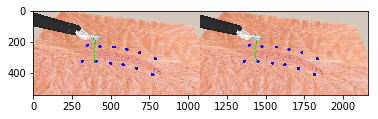

In [5]:
plt.imshow(np.hstack((left_image, right_image)))

In [6]:
tf_listener = tf.TransformListener()
time.sleep(1)
tf_listener.getFrameStrings()

/opt/ros/melodic/lib/python2.7/dist-packages/tf/listener.py:97: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(self._buffer.all_frames_as_yaml()) or {}


['ECM_RCM',
 'PSM1_clip',
 'ECM',
 'PSM2_base',
 'simcamera',
 'PSM1_RCM',
 'PSM1_base',
 'PSM1',
 'PSM2_RCM',
 'PSM2',
 'ECM_base',
 'PSM2_clip']

In [7]:
psm1 = dvrk.psm('PSM1')
psm2 = dvrk.psm('PSM2')
ecm = dvrk.ecm('ECM')
while ecm.get_current_position() == PyKDL.Frame() or ecm.get_desired_position() == PyKDL.Frame():
    time.sleep(0.5)
while psm1.get_current_position() == PyKDL.Frame() or psm1.get_desired_position() == PyKDL.Frame():
    time.sleep(0.5)

In [8]:
# ECM_STARTING_JOINT_POS = np.asarray([-0.15669435,  0.17855662,  0.07069676,  0.17411496])
# ECM_STARTING_JOINT_POS = np.asarray([0.0615668 , 0.0523214 , 0.04854392, 0.15809197])
# ECM_STARTING_JOINT_POS = np.asarray([-0.14478268, -0.1293848 ,  0.00261061,  0.043541  ])
# ECM_STARTING_JOINT_POS = np.asarray([0, 0 ,  0.05,  0.043541  ])
ECM_STARTING_JOINT_POS = np.asarray([0, -0.1 ,  0.05,  0.043541  ])
ecm.move_joint(ECM_STARTING_JOINT_POS)

True

In [9]:
time.sleep(1)
PSM_HOME_POS = np.asarray([0., 0., 0.05, 0., 0., 0.])
psm1.move_joint(PSM_HOME_POS)
psm1.close_jaw()

psm2.move_joint(PSM_HOME_POS)
psm2.close_jaw()

True

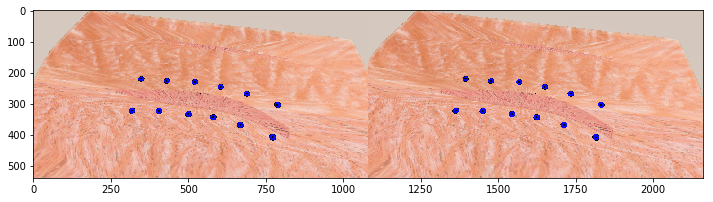

In [10]:
import image_geometry
utils = None
import utils
stereo_model = image_geometry.StereoCameraModel()
stereo_model.fromCameraInfo(left_camera_info, right_camera_info)

tf_cam_to_world = utils.tf_to_pykdl_frame(tf_listener.lookupTransform('simworld', 'simcamera', rospy.Time()))
tf_world_to_psm1 = \
    utils.tf_to_pykdl_frame(tf_listener.lookupTransform('PSM1_base', 'simworld', rospy.Time()))
tf_world_to_psm2 = \
    utils.tf_to_pykdl_frame(tf_listener.lookupTransform('PSM2_base', 'simworld', rospy.Time()))

objects, frame = utils.get_points_and_img(left_image_msg, right_image_msg, stereo_model, tf_cam_to_world)
plt.figure(figsize=(12, 5))
plt.imshow(frame)
for o in objects:
    o = PyKDL.Vector(o.x(), o.y(), o.z())
#     o = PyKDL.Vector(o.x(), o.y(), o.z())

In [11]:
len(objects)

12

In [12]:
# pair up points that are across from each other
# x is *more or less* the axis along the wound
paired_pts = []
while objects:
    pt = objects[0]
    objects.remove(pt)
#     pt2 = min(objects, key=lambda obj : abs(obj.x() - pt.x()))
    pt2 = min(objects, key=lambda obj : abs(obj.y() - pt.y()))
    objects.remove(pt2)
#     paired_pts.append(
#         (max(pt, pt2, key=lambda p: p.y()), min(pt, pt2, key=lambda p: p.y())))
    paired_pts.append(
        (max(pt, pt2, key=lambda p: p.x()), min(pt, pt2, key=lambda p: p.x())))
print(paired_pts[0][0][1])
print(paired_pts[1][0][1])
paired_pts = sorted(paired_pts,key=lambda p: float(p[0][1]))
print("paired points sorted:")
paired_pts

-0.0273225697928
-0.014135693432
paired points sorted:


[([    -1.52334,  -0.0273226,    0.647382],
  [    -1.53795,  -0.0224317,    0.648044]),
 ([    -1.51766,  -0.0141357,    0.649739],
  [    -1.53111,  -0.0096722,    0.647282]),
 ([    -1.51238, -0.00292427,    0.647861],
  [    -1.52727,  0.00194213,    0.648817]),
 ([    -1.50773,  0.00873028,    0.645436],
  [    -1.52396,   0.0127208,    0.646255]),
 ([    -1.50619,   0.0220289,    0.645874],
  [    -1.52305,   0.0251839,     0.65029]),
 ([    -1.50434,    0.033975,     0.64648],
  [    -1.52054,    0.037799,    0.647316])]

In [ ]:
import suturing_state_machine_single_needle
reload(suturing_state_machine_single_needle)
reload(utils)
import time
pts_psm1 = paired_pts[:3]
pts_psm2 = paired_pts[3:]
# pts_psm2 = []

# for sublist in (paired_pts[3:]):
#     pts_psm2.append(sublist[::-1])

sm = suturing_state_machine_single_needle.SuturingStateMachine(psm1, psm2, tf_world_to_psm1,tf_world_to_psm2,  paired_pts )  
start_time = time.clock()
while not sm.is_done():
    sm.run_once()
    time.sleep(0.1)
completion_time = time.clock() - start_time
print("completion time(s): ",completion_time)

In [ ]:
dir(psm1)

In [ ]:
ecm.get_current_joint_position()

In [ ]:
psm2.close_jaw()